In [1]:
import matplotlib.pyplot as plt
from sim_pipeline.gg_lens_pop import GGLensPop
%matplotlib inline


In [2]:
# define a cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
from astropy.units import Quantity
sky_area = Quantity(value=0.1, unit='deg2')


# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_lens_cut = {'band': 'g', 'band_max':25, 'z_min': 0.01, 'z_max': .5}
kwargs_source_cut = {'band': 'g', 'band_max':25, 'z_min': 0.1, 'z_max': 5.}


# run skypy pipeline and make galaxy-galaxy population class
gg_lens_pop = GGLensPop(lens_type='early-type', source_type='galaxies', 
                        kwargs_lens_cut=kwargs_lens_cut, kwargs_source_cut=kwargs_source_cut,
                        kwargs_mass2light=None, skypy_config=None, sky_area=sky_area, cosmo=cosmo)


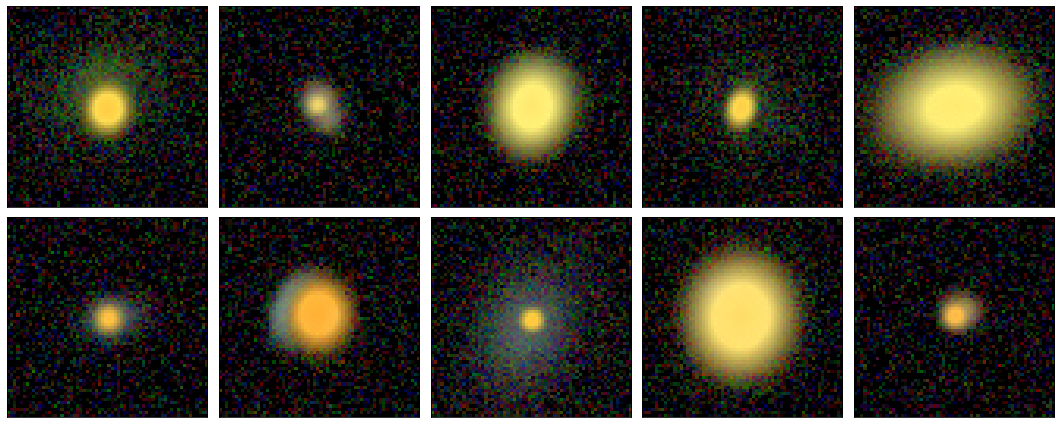

In [3]:
# make montage of realizations
from sim_pipeline.Plots.gg_plots import GGLensingPlots
gg_plot = GGLensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)

fig, axes = gg_plot.plot_montage(rgb_band_list=['i', 'r', 'g'], add_noise=True, n_horizont=5, n_vertical=2)
plt.show()


In [4]:
kwargs_lens_cuts = {'mag_arc_limit': {'g': 25}}

gg_lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

In [5]:
import numpy as np

print('Number of lenses:', len(gg_lens_population))

lens_samples = []
labels = [r'$\sigma_v$', r'$\log(M_{*})$', r'$\theta_E$', r'$z_{\rm l}$', r'$z_{\rm s}$']

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.lens_redshift
    zs = gg_lens.source_redshift
    lens_samples.append([vel_disp, np.log10(m_star), theta_e, zl, zs])



Number of lenses: 84


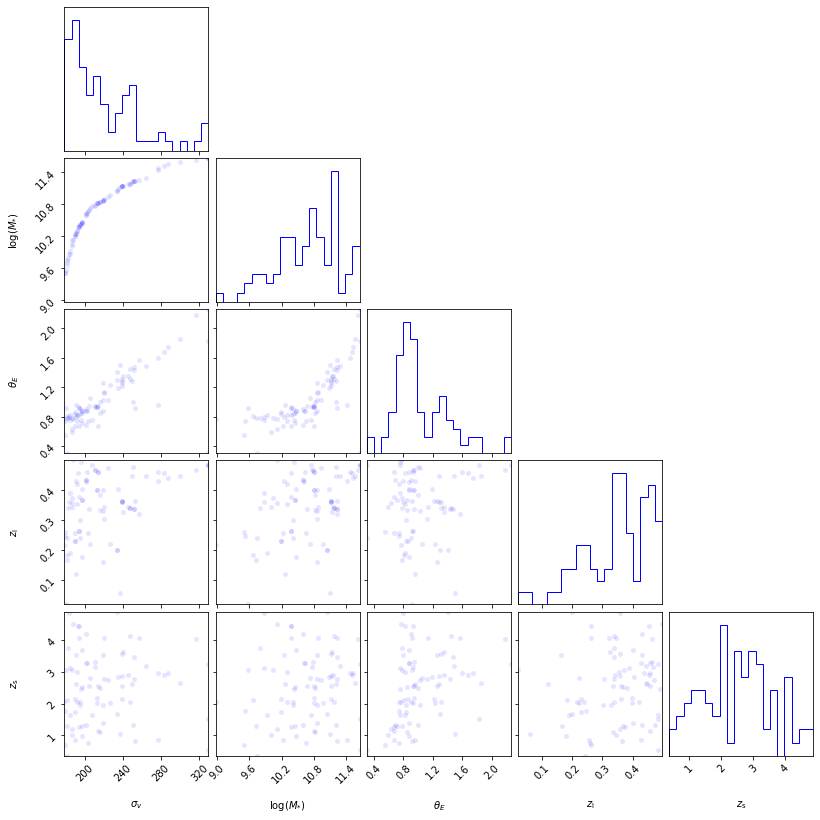

In [6]:
import corner

hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': 'b',
               'data_kwargs': {'ms': 5}}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()